In [1]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(".."))
pd.set_option("display.precision", 2)
from ficaria.missing_imputation import FCMCentroidImputer, FCMParameterImputer, FCMRoughParameterImputer
from ficaria.feature_selection import WeightedFuzzyRoughSelector

### FS

In [2]:
np.random.seed(42)

n = 100

living_area = np.random.randint(40, 121, n)
num_rooms = np.clip((living_area / 20 + np.random.normal(0, 0.8, n)).round(), 1, 6).astype(int)
districts = np.random.choice(["A", "B", "C", "D"], size=n, p=[0.25, 0.25, 0.25, 0.25])
distance_to_park = np.random.randint(200, 2000, n)
roof_type = np.random.choice(["Flat", "Gable", "Hip"], size=n)

district_effect = {"A": 0, "B": 5, "C": 10, "D": 15}

price = (
    2.5 * living_area
    + 10 * num_rooms
    + [district_effect[d] for d in districts]
    + np.random.normal(0, 15, n)
)

price = (price / 10).round(1)

id_col = np.arange(1, n + 1)
tech = np.ones(n, dtype=int)

data = pd.DataFrame({
    "id": id_col,
    "living_area": living_area,
    "num_rooms": num_rooms,
    "district": districts,
    "distance_to_park": distance_to_park,
    "roof_type": roof_type,
    "price": price,
    "tech": tech
})

In [3]:
# data = pd.DataFrame({
#     "living_area": [50, 55, 60, 65, 70, 75, 80, 85, 90, 95],           # silnie skorelowane z price
#     "num_rooms": [2, 2, 3, 3, 3, 4, 4, 5, 5, 5],                      # średnia korelacja z price
#     "district": ["A", "A", "B", "B", "B", "C", "C", "C", "D", "D"],   # lekka korelacja z price
#     "distance_to_park": [430, 1200, 850, 670, 910, 500, 1500, 950, 400, 1300],  # losowe
#     "roof_type": ["Flat", "Gable", "Flat", "Gable", "Hip", "Flat", "Flat", "Hip", "Gable", "Flat"],  # losowe
#     "price": [210, 230, 250, 270, 290, 310, 330, 350, 370, 390]        # target (np. tys. USD)
# })

X = data.drop(columns=['price'])
y = data['price']

selector = WeightedFuzzyRoughSelector(n_features=3)
feature_importance = selector.fit(X, y)

In [4]:
selector.feature_importances_

,feature,importance
0,living_area,0.63
1,id,0.53
2,distance_to_park,0.49
3,num_rooms,0.44
4,district,0.43
5,roof_type,0.43
6,tech,0.43


In [19]:
from catboost import CatBoostRegressor, Pool

cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    verbose=False,
    random_seed=42
)

train_pool = Pool(X, y, cat_features=cat_features)
model.fit(train_pool)

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.get_feature_importance(train_pool)
}).sort_values(by='importance', ascending=False)

print(feature_importances.head(10))

            feature  importance
1       living_area       74.08
2         num_rooms       15.81
4  distance_to_park        3.58
0                id        2.93
3          district        2.57
5         roof_type        1.03
6              tech        0.00


In [21]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X, y, n_repeats=10, random_state=42)

perm_importances = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(perm_importances.head(10))

            feature  importance_mean  importance_std
1       living_area         1.19e+00        1.16e-01
2         num_rooms         1.19e-01        1.47e-02
4  distance_to_park         1.17e-02        1.33e-03
0                id         1.09e-02        1.74e-03
3          district         9.00e-03        1.33e-03
5         roof_type         7.29e-03        1.18e-03
6              tech         0.00e+00        0.00e+00


#### Eksperyment

k = 1 features → accuracy = 0.5926
k = 2 features → accuracy = 0.7407
k = 3 features → accuracy = 0.7407
k = 4 features → accuracy = 0.8148
k = 5 features → accuracy = 0.8148
k = 6 features → accuracy = 0.8333
k = 7 features → accuracy = 0.9074
k = 8 features → accuracy = 0.8333
k = 9 features → accuracy = 0.8704
k = 10 features → accuracy = 0.9074
k = 11 features → accuracy = 0.9630
k = 12 features → accuracy = 0.9444
k = 13 features → accuracy = 0.9444


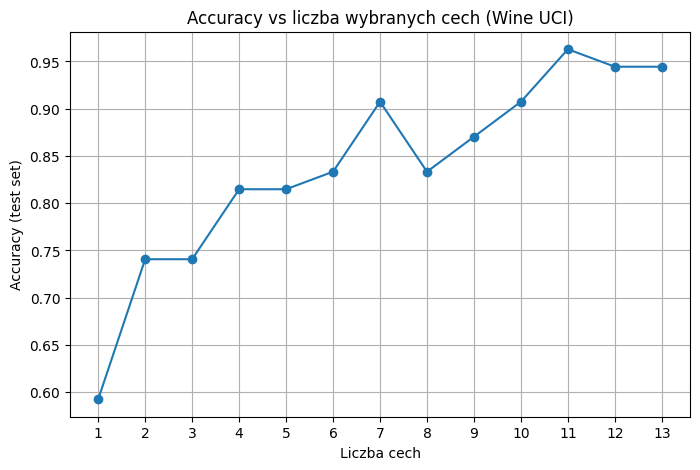

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# 1. Załaduj dane
data = load_wine(as_frame=True)
X_full = data.data
y = data.target
feature_names = X_full.columns.tolist()

# 2. Standaryzacja cech (ważne, bo cechy mają różne skale)  
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
X_full = pd.DataFrame(X_full_scaled, columns=feature_names)

# 3. Podziel dane na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.3, stratify=y, random_state=42
)

# 4. Przygotuj pętlę eksperymentalną
n_features_total = X_full.shape[1]  # powinno być 13 dla Wine :contentReference[oaicite:3]{index=3}
accuracies = []

for k in range(1, n_features_total + 1):
    # 4a. Utwórz selektor, ustaw n_features=k
    selector = WeightedFuzzyRoughSelector(n_features=k, alpha=1.0, k=5)
    
    # 4b. Fit przeprowadza selekcję cech na zbiorze treningowym
    selector.fit(X_train, y_train)
    
    # 4c. Przekształć dane treningowe i testowe zgodnie z wybranymi cechami
    X_train_sel = selector.transform(X_train)
    X_test_sel  = selector.transform(X_test)
    
    # 4d. Trenuj klasyfikator k=3
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train_sel, y_train)
    
    # 4e. Predykcja i ocena
    y_pred = clf.predict(X_test_sel)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"k = {k} features → accuracy = {acc:.4f}")

# 5. Rysowanie wykresu
plt.figure(figsize=(8,5))
plt.plot(range(1, n_features_total+1), accuracies, marker='o')
plt.title("Accuracy vs liczba wybranych cech (Wine UCI)")
plt.xlabel("Liczba cech")
plt.ylabel("Accuracy (test set)")
plt.grid(True)
plt.xticks(range(1, n_features_total+1))
plt.show()


In [16]:
import requests
from io import StringIO

# 1. Pobierz dane Sonar (UCI repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
response = requests.get(url)
data = pd.read_csv(StringIO(response.text), header=None)

# Ostatnia kolumna to target: 'R' = Rock, 'M' = Mine
X_full = data.iloc[:, :-1]
y = data.iloc[:, -1].map({'R':0, 'M':1})  # zamiana na 0/1
feature_names = X_full.columns.tolist()

# 2. Standaryzacja cech
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
X_full = pd.DataFrame(X_full_scaled, columns=feature_names)

# 3. Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.3, stratify=y, random_state=42
)

# 4. Pętla eksperymentalna
n_features_total = X_full.shape[1]  # 60 cech w Sonar
accuracies = []

for k in range(1, n_features_total + 1):
    selector = WeightedFuzzyRoughSelector(n_features=k, alpha=1.0, k=5)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
    
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train_sel, y_train)
    
    y_pred = clf.predict(X_test_sel)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"k = {k} features → accuracy = {acc:.4f}")

# 5. Wykres
plt.figure(figsize=(10,6))
plt.plot(range(1, n_features_total+1), accuracies, marker='o')
plt.title("Accuracy vs liczba wybranych cech (Sonar UCI)")
plt.xlabel("Liczba cech")
plt.ylabel("Accuracy (test set)")
plt.grid(True)
plt.xticks(range(1, n_features_total+1, 2))
plt.show()


KeyboardInterrupt: 

### MI

In [ ]:
# Sample data
data = pd.DataFrame({
    'age': [25, 26, 28, 51, 53, 72, 75, np.nan],
    'income': [50000, 55000, 58000, 85000, 90000, 120000, 125000, 100000]
})

imputer = FCMCentroidImputer(n_clusters=3)
imputer.fit(data)
filled_data = imputer.transform(data)

print(filled_data)

    age  income
0  25.0   50000
1  26.0   55000
2  28.0   58000
3  51.0   85000
4  53.0   90000
5  72.0  120000
6  75.0  125000
7  52.0  100000


In [3]:
data = pd.DataFrame({
    'systolic_bp': [120, 130, 125, np.nan, 140, 135, np.nan, 150],
    'diastolic_bp': [80, 85, np.nan, 88, 90, 82, 95, 100],
    'heart_rate': [70, 72, 75, np.nan, 78, 80, 76, np.nan]
})

imputer = FCMParameterImputer(n_clusters=3)
imputer.fit(data)
filled_data = imputer.transform(data)

print(filled_data)

   systolic_bp  diastolic_bp  heart_rate
0       120.00         80.00       70.00
1       130.00         85.00       72.00
2       125.00         82.15       75.00
3       138.15         88.00       77.45
4       140.00         90.00       78.00
5       135.00         82.00       80.00
6       136.95         95.00       76.00
7       150.00        100.00       76.95


In [4]:
data = pd.DataFrame({
    'temperature': [21.5, 22.0, np.nan, 23.1, 21.8, 22.3, np.nan, 22.7],
    'humidity': [40, 42, 38, np.nan, 41, 43, 39, np.nan],
    'pressure': [1012, 1013, 1011, 1010, np.nan, 1014, 1012, np.nan]
})

imputer = FCMRoughParameterImputer(n_clusters=3, max_iter=1000)
imputer.fit(data)
filled_data = imputer.transform(data)
print(filled_data)

   temperature  humidity  pressure
0         21.5      40.0    1012.0
1         22.0      42.0    1013.0
2         21.5      38.0    1011.0
3         23.1      40.0    1010.0
4         21.8      41.0    1013.0
5         22.3      43.0    1014.0
6         21.5      39.0    1012.0
7         22.7      43.0    1014.0
